Transfer Learning has 2 types.
1. Feature Extraction
2. Fine Tunning

This code is for Type 2: **Fine Tunning**.
In Fine Tunning, we freeze the first few convolution layer of the pre-trained model to prevent them getting trained and we focus on mainly Last conv layer and FC layer and build the a new model and train these layers to predict the output.


Code will consist of 2 Type of Techniques.
1. Fine Tunning without Data Augmentation
2. Fine Tunning with Data Augmentation.

Dataset used will be a Cats Vs Dogs Classifier data from Kaggle.com
and the pretrainned model we will be using is VGG16

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d salader/dogs-vs-cats

100% 1.06G/1.06G [00:10<00:00, 170MB/s]
100% 1.06G/1.06G [00:10<00:00, 110MB/s]


In [3]:
import zipfile
zip = zipfile.ZipFile('/content/dogs-vs-cats.zip')
zip.extractall('/content/')
zip.close()

In [4]:
# Importing the dependencies

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, load_img , array_to_img , img_to_array

import matplotlib.pyplot as plt


#Transfer Learning(Type :II Fine Tunning) without Data Augmentation

In [15]:
# Initializing the VGG16 Model Object (Pre-Trained Model)

conv_base = VGG16(
    weights = 'imagenet',
    include_top= False, # To eliminate FC Layer part (ANN part)
    input_shape = (150,150,3)
    )

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

As we can see the last Layer is MaxPooling Hence FC Layer(ANN Part) is eliminated

In [16]:
# ## Freezeing the Training for first 4 Conv layer and Activating for the last layer

conv_base.trainable = True # This will set all trainable parameters of all conv layer to False

x = False

# Apply The Changes to the last Layer

for i in conv_base.layers:
  if i.name == 'block5_conv1' :
    x = True
  if x :
    i.trainable = True
  else:
    i.trainable=False

## Checking Result

for i in conv_base.layers:
  print(i.name , i.trainable)


input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


As we can see only the last layer parameters are true now and for rest it false.


In [17]:

## Checking the conv_base summary after making changes into trainable paramerts

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

As we can see No of trainingable parameters are redcued to 7M from 14M


In [27]:
## Building the Model

model = Sequential()

## Adding pre-trained model Conv_base and Flattening it

model.add(conv_base)
model.add(Flatten())

## Building Futher ANN

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 9177089 (35.01 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


In [19]:
# Generators

train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    label_mode = 'int',
    labels = 'inferred',
    batch_size = 32,
    image_size=(150,150)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    label_mode = 'int',
    labels = 'inferred',
    batch_size = 32,
    image_size=(150,150)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [20]:
## Normalization

def normalize(image, label):
  image = tf.cast(image/255.0, tf.float16)

  return image, label

train_ds = train_ds.map(normalize)
validation_ds = validation_ds.map(normalize)

In [22]:
# Compiling the Model
# It is advisable to use RMSprop as an optimizer for Fine Tunning with low learing rate.

model.compile(optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5), loss = 'binary_crossentropy', metrics=['accuracy'])

In [23]:
# Fitting the Model

history = model.fit(train_ds, epochs = 10, validation_data = validation_ds)

Epoch 1/10
625/625 [==============================] - 63s 99ms/step - loss: 0.2341 - accuracy: 0.9021 - val_loss: 0.1541 - val_accuracy: 0.9390
Epoch 2/10
625/625 [==============================] - 62s 99ms/step - loss: 0.1332 - accuracy: 0.9480 - val_loss: 0.1343 - val_accuracy: 0.9448
Epoch 3/10
625/625 [==============================] - 62s 99ms/step - loss: 0.0914 - accuracy: 0.9666 - val_loss: 0.1282 - val_accuracy: 0.9482
Epoch 4/10
625/625 [==============================] - 62s 99ms/step - loss: 0.0642 - accuracy: 0.9772 - val_loss: 0.1228 - val_accuracy: 0.9510
Epoch 5/10
625/625 [==============================] - 62s 99ms/step - loss: 0.0444 - accuracy: 0.9861 - val_loss: 0.1546 - val_accuracy: 0.9434
Epoch 6/10
625/625 [==============================] - 62s 99ms/step - loss: 0.0296 - accuracy: 0.9922 - val_loss: 0.1307 - val_accuracy: 0.9524
Epoch 7/10
625/625 [==============================] - 62s 98ms/step - loss: 0.0187 - accuracy: 0.9959 - val_loss: 0.1372 - val_accuracy:

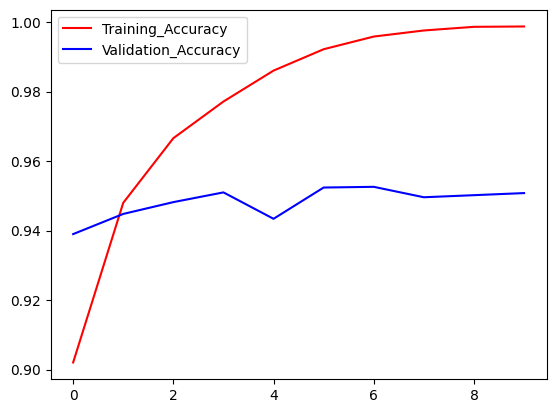

In [24]:
## Plotting the accuracy

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], color = 'red', label = 'Training_Accuracy')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'Validation_Accuracy')
plt.legend()
plt.show()

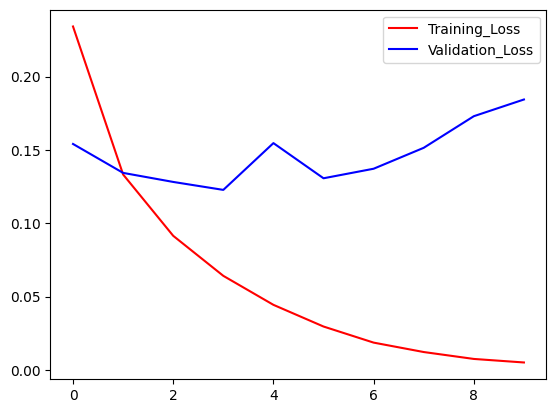

In [25]:
## Plotting the Losses

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], color = 'red', label = 'Training_Loss')
plt.plot(history.history['val_loss'], color = 'blue', label = 'Validation_Loss')
plt.legend()
plt.show()

Model is showing great result. lets try with data augmentation.

#Transfer Learning(Type :II Fine Tunning) with Data Augmentation

In [26]:
batch_size = 32

train_img_gen = ImageDataGenerator(
    rescale = 1/255.0,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range= 0.2
)

test_img_gen = ImageDataGenerator(rescale = 1/255.0)

train_ds1 = train_img_gen.flow_from_directory(
    directory = '/content/train',
    target_size = (150,150),
    batch_size = batch_size,
    class_mode='binary'

)

validation_ds1 = test_img_gen.flow_from_directory(
    directory = '/content/test',
    target_size = (150,150),
    batch_size = batch_size,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
# Rerunning the Model above Model again before compiling stage

In [29]:
# Compiling the Model

model.compile(optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5), loss = 'binary_crossentropy', metrics=['accuracy'])

In [30]:
# Training the Model

history1 = model.fit(train_ds1, epochs = 10, validation_data = validation_ds1)

Epoch 1/10
625/625 [==============================] - 155s 245ms/step - loss: 0.1464 - accuracy: 0.9424 - val_loss: 0.1340 - val_accuracy: 0.9476
Epoch 2/10
625/625 [==============================] - 156s 249ms/step - loss: 0.1007 - accuracy: 0.9591 - val_loss: 0.1858 - val_accuracy: 0.9294
Epoch 3/10
625/625 [==============================] - 154s 246ms/step - loss: 0.0866 - accuracy: 0.9662 - val_loss: 0.1128 - val_accuracy: 0.9556
Epoch 4/10
625/625 [==============================] - 155s 248ms/step - loss: 0.0744 - accuracy: 0.9718 - val_loss: 0.1187 - val_accuracy: 0.9548
Epoch 5/10
625/625 [==============================] - 156s 250ms/step - loss: 0.0644 - accuracy: 0.9750 - val_loss: 0.1210 - val_accuracy: 0.9562
Epoch 6/10
625/625 [==============================] - 155s 248ms/step - loss: 0.0534 - accuracy: 0.9804 - val_loss: 0.1231 - val_accuracy: 0.9570
Epoch 7/10
625/625 [==============================] - 157s 251ms/step - loss: 0.0526 - accuracy: 0.9811 - val_loss: 0.1300 -

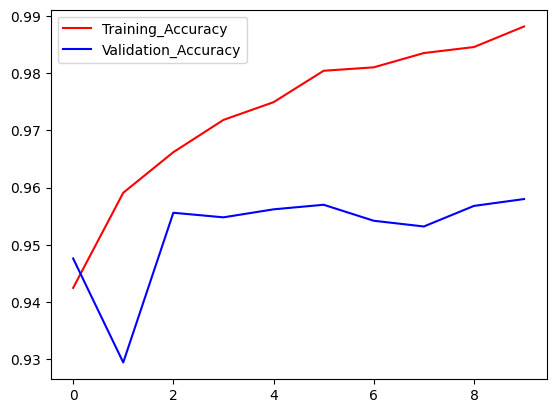

In [31]:
## Plotting the accuracy

import matplotlib.pyplot as plt

plt.plot(history1.history['accuracy'], color = 'red', label = 'Training_Accuracy')
plt.plot(history1.history['val_accuracy'], color = 'blue', label = 'Validation_Accuracy')
plt.legend()
plt.show()

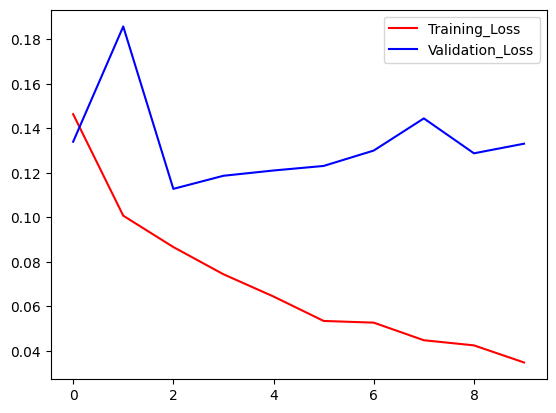

In [32]:
## Plotting the Losses

import matplotlib.pyplot as plt

plt.plot(history1.history['loss'], color = 'red', label = 'Training_Loss')
plt.plot(history1.history['val_loss'], color = 'blue', label = 'Validation_Loss')
plt.legend()
plt.show()

In [ ]:
# Overfitting has been reduced drastically.